## Exercice 2 : La Colorisation Automatique

**Objectif :** Prédire les couleurs d'une scène à partir de sa version grise.

* **Dataset :** **Flowers 102** (recommandé pour les couleurs vives), sinon **STL10** ou **CIFAR-10**.
* **Méthode :** Convertissez vos images RGB en niveaux de gris pour l'entrée. Le réseau doit ressortir une image à 3 canaux.
* **Code Noir & Blanc :** `x_train_gray = tf.image.rgb_to_grayscale(x_train)

In [120]:
# --- imput ---

import matplotlib.pyplot as plt
import tensorflow as tf

from skimage.color import rgb2lab, lab2rgb

from tensorflow.keras import layers, models, datasets
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Rescaling, Reshape
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, UpSampling2D, BatchNormalization, Concatenate
from tensorflow.keras.layers import Conv2DTranspose

import tensorflow as tf
import tensorflow_datasets as tfds
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [121]:
# --- 2. DATASET POUR LA COLORISATION (FLOWERS 102) ---
# Note : ds_flowers est un dictionnaire contenant 'train', 'test' et 'validation'

DATA_DIR = "datasets/tfds"   # любая папка, например рядом с проектом

ds_flowers, info_flowers = tfds.load(
    'oxford_flowers102',
    data_dir=DATA_DIR,
    with_info=True,
    as_supervised=True
)

In [122]:

print(info_flowers.splits)

{'train': <SplitInfo num_examples=1020, num_shards=1>, 'test': <SplitInfo num_examples=6149, num_shards=2>, 'validation': <SplitInfo num_examples=1020, num_shards=1>}


In [ ]:
# Paramètres
BATCH_SIZE = 16
IMG_SIZE = (128, 128) # Redimensionnement automatique 

train_ds = tf.keras.utils.image_dataset_from_directory(
    'datasets/jpg',
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    label_mode=None,            # pour autoencoder / colorisation
    validation_split=0.2,       # 20% pour validation
    subset='training',           # prend pour train
    seed=42                      
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    'datasets/jpg',
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    label_mode=None,
    validation_split=0.2,
    subset='validation',         # prend pour val
    seed=42
)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 8189 files.
Using 6552 files for training.
Found 8189 files.
Using 1637 files for validation.


In [124]:
for images in train_ds.take(1):
    print(images.shape)  # 

(32, 128, 128, 3)


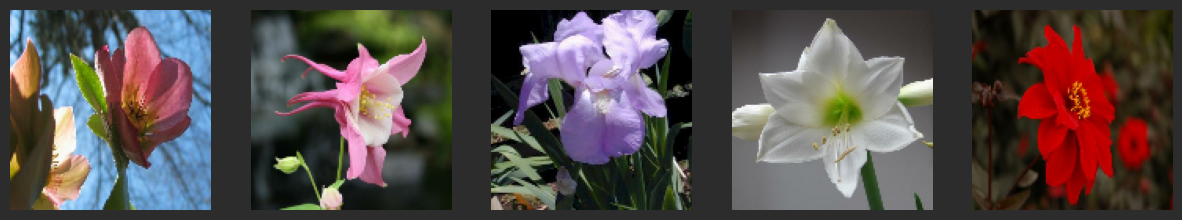

In [125]:
def show_batch_img(ds, n=5):

    for images in ds.take(1):
        fig, axes = plt.subplots(1, n, figsize=(15, 5))
        for i in range(n):
            idx = np.random.randint(images.shape[0]) 
            axes[i].imshow(images[idx].numpy().astype("uint8")) 
            axes[i].axis("off")
        plt.show()
        break

show_batch_img(train_ds, 5)

In [ ]:
# --- trnsfomation into gray with normalisation, cration structure: (input, target) ---
from skimage.color import rgb2lab
import tensorflow as tf
import numpy as np

def transform_gray_fast(ds, img_size=(128,128)):


    def rgb_to_lab_batch(batch):
        batch = tf.cast(batch, tf.float32) / 255.0
        batch_np = batch.numpy()
        lab_batch = np.array([rgb2lab(img) for img in batch_np])
        L = lab_batch[..., 0:1] / 100.0
        ab = (lab_batch[..., 1:3] + 128) / 255.0
        return L.astype(np.float32), ab.astype(np.float32)

    def tf_map(batch):
        L, ab = tf.py_function(rgb_to_lab_batch, [batch], [tf.float32, tf.float32])
        # --- фиксируем только H/W/C, оставляем batch_size динамическим ---
        L.set_shape([None, img_size[0], img_size[1], 1])
        ab.set_shape([None, img_size[0], img_size[1], 2])
        return L, ab

    ds_lab = ds.map(tf_map, num_parallel_calls=tf.data.AUTOTUNE)
    ds_lab = ds_lab.prefetch(tf.data.AUTOTUNE)
    return ds_lab



In [127]:

def show_predictions(ds, n=5):
    """
    Визуализация нескольких примеров из Dataset transform_gray:
    - Input (grayscale L)
    - Target (RGB)
    Можно добавить Predicted позже.
    """
    for x_batch, y_batch in ds.take(1):
        batch_size = x_batch.shape[0]
        fig, axes = plt.subplots(2, n, figsize=(15, 6))

        for i in range(n):
            idx = np.random.randint(batch_size)

            # --- Input grayscale ---
            gray = x_batch[idx, :, :, 0]
            axes[0, i].imshow(gray, cmap='gray')
            axes[0, i].axis('off')
            axes[0, i].set_title("Input (L)")

            # --- Target RGB ---
            L = gray * 100.0
            ab_true = y_batch[idx].numpy() * 255.0 - 128.0
            lab_true = np.concatenate([L[..., np.newaxis], ab_true], axis=-1)
            rgb_true = lab2rgb(lab_true)
            axes[1, i].imshow(rgb_true)
            axes[1, i].axis('off')
            axes[1, i].set_title("Target (RGB)")

        plt.show()
        break



In [128]:
# --- trnsfomation into gray with normalisation, cration structure: (input, target) ---
train_gray_ds = transform_gray(train_ds)
val_gray_ds = transform_gray(val_ds)


for x_batch, y_batch in train_gray_ds.take(1):
    print("x_batch shape:", x_batch.shape)
    print("y_batch shape:", y_batch.shape)
    break

x_batch shape: (32, 128, 128, 1)
y_batch shape: (32, 128, 128, 2)


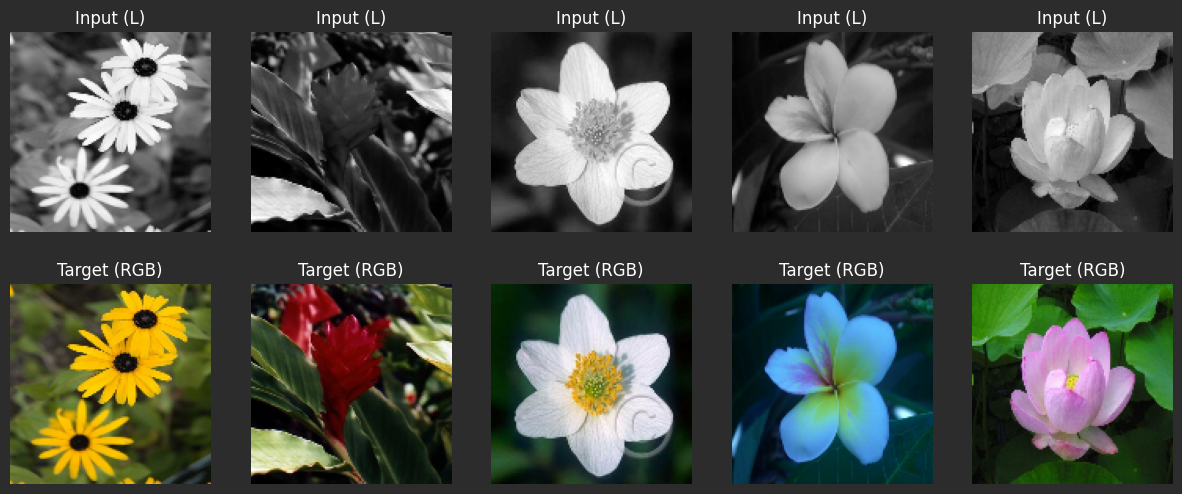

In [129]:
show_predictions(train_gray_ds, n=5)

### --- Model ---

In [132]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, BatchNormalization
from tensorflow.keras.models import Model

def build_lab_unet(img_size=(128,128,1)):

    input_img = Input(shape=img_size)  # L channel

    # -------- Encoder --------
    c1 = Conv2D(64, 3, activation='relu', padding='same')(input_img)
    c1 = BatchNormalization()(c1)
    p1 = MaxPooling2D(2, padding='same')(c1)  # 224 → 112

    c2 = Conv2D(128, 3, activation='relu', padding='same')(p1)
    c2 = BatchNormalization()(c2)
    p2 = MaxPooling2D(2, padding='same')(c2)  # 112 → 56

    c3 = Conv2D(256, 3, activation='relu', padding='same')(p2)
    c3 = BatchNormalization()(c3)
    p3 = MaxPooling2D(2, padding='same')(c3)  # 56 → 28

    c4 = Conv2D(512, 3, activation='relu', padding='same')(p3)
    c4 = BatchNormalization()(c4)              # 28
    # no further pooling

    # -------- Decoder --------
    u3 = UpSampling2D(2)(c4)  # 28 → 56
    u3 = Concatenate()([u3, c3])
    c5 = Conv2D(256, 3, activation='relu', padding='same')(u3)
    c5 = BatchNormalization()(c5)

    u2 = UpSampling2D(2)(c5)  # 56 → 112
    u2 = Concatenate()([u2, c2])
    c6 = Conv2D(128, 3, activation='relu', padding='same')(u2)
    c6 = BatchNormalization()(c6)

    u1 = UpSampling2D(2)(c6)  # 112 → 224
    u1 = Concatenate()([u1, c1])
    c7 = Conv2D(64, 3, activation='relu', padding='same')(u1)
    c7 = BatchNormalization()(c7)

    # -------- Output --------
    output_ab = Conv2D(2, 1, activation='tanh')(c7)  # ab channels normalized [-1,1]

    model = Model(input_img, output_ab)
    model.compile(optimizer='adam', loss='mae')

    return model

# создаём модель
IMG_SIZE = (128, 128,1)
model = build_lab_unet(IMG_SIZE)
model.summary()


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_78 (Conv2D)  │ (None, 128, 128,  │        640 │ input_layer_11[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_78[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_28    │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_79 (Conv2D)  │ (None, 64, 64,    │     73,856 │ max_pooling2d_28… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_79[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_29    │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_80 (Conv2D)  │ (None, 32, 32,    │    295,168 │ max_pooling2d_29… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │      1,024 │ conv2d_80[0][0]   │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_30    │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_81 (Conv2D)  │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_30… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │      2,048 │ conv2d_81[0][0]   │
│ (BatchNormalizatio… │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_28    │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (UpSampling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_28      │ (None, 32, 32,    │          0 │ up_sampling2d_28… │
│ (Concatenate)       │ 768)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_82 (Conv2D)  │ (None, 32, 32,    │  1,769,728 │ concatenate_28[0… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │      1,024 │ conv2d_82[0][0]   │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_29    │ (None, 64, 64,    │          0 │ batch_normalizat

 Total params: 3,878,466 (14.80 MB)

 Trainable params: 3,875,650 (14.78 MB)

 Non-trainable params: 2,816 (11.00 KB)

In [133]:
# --- autoencoder fitting ---

history = model.fit(
    train_gray_ds,         
    epochs=5,
    validation_data=val_gray_ds  
)

Epoch 1/5
204/205 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.2133

InvalidArgumentError: Graph execution error:

Detected at node IteratorGetNext defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "c:\Users\Utilisateur\Simplon\CONV_NN\.venv\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>

  File "c:\Users\Utilisateur\Simplon\CONV_NN\.venv\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance

  File "c:\Users\Utilisateur\Simplon\CONV_NN\.venv\Lib\site-packages\ipykernel\kernelapp.py", line 758, in start

  File "c:\Users\Utilisateur\Simplon\CONV_NN\.venv\Lib\site-packages\tornado\platform\asyncio.py", line 211, in start

  File "C:\Users\Utilisateur\AppData\Local\Programs\Python\Python311\Lib\asyncio\base_events.py", line 608, in run_forever

  File "C:\Users\Utilisateur\AppData\Local\Programs\Python\Python311\Lib\asyncio\base_events.py", line 1936, in _run_once

  File "C:\Users\Utilisateur\AppData\Local\Programs\Python\Python311\Lib\asyncio\events.py", line 84, in _run

  File "c:\Users\Utilisateur\Simplon\CONV_NN\.venv\Lib\site-packages\ipykernel\kernelbase.py", line 614, in shell_main

  File "c:\Users\Utilisateur\Simplon\CONV_NN\.venv\Lib\site-packages\ipykernel\kernelbase.py", line 471, in dispatch_shell

  File "c:\Users\Utilisateur\Simplon\CONV_NN\.venv\Lib\site-packages\ipykernel\ipkernel.py", line 366, in execute_request

  File "c:\Users\Utilisateur\Simplon\CONV_NN\.venv\Lib\site-packages\ipykernel\kernelbase.py", line 827, in execute_request

  File "c:\Users\Utilisateur\Simplon\CONV_NN\.venv\Lib\site-packages\ipykernel\ipkernel.py", line 458, in do_execute

  File "c:\Users\Utilisateur\Simplon\CONV_NN\.venv\Lib\site-packages\ipykernel\zmqshell.py", line 663, in run_cell

  File "c:\Users\Utilisateur\Simplon\CONV_NN\.venv\Lib\site-packages\IPython\core\interactiveshell.py", line 3123, in run_cell

  File "c:\Users\Utilisateur\Simplon\CONV_NN\.venv\Lib\site-packages\IPython\core\interactiveshell.py", line 3178, in _run_cell

  File "c:\Users\Utilisateur\Simplon\CONV_NN\.venv\Lib\site-packages\IPython\core\async_helpers.py", line 128, in _pseudo_sync_runner

  File "c:\Users\Utilisateur\Simplon\CONV_NN\.venv\Lib\site-packages\IPython\core\interactiveshell.py", line 3400, in run_cell_async

  File "c:\Users\Utilisateur\Simplon\CONV_NN\.venv\Lib\site-packages\IPython\core\interactiveshell.py", line 3641, in run_ast_nodes

  File "c:\Users\Utilisateur\Simplon\CONV_NN\.venv\Lib\site-packages\IPython\core\interactiveshell.py", line 3701, in run_code

  File "C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_1828\1041288493.py", line 3, in <module>

  File "c:\Users\Utilisateur\Simplon\CONV_NN\.venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\Utilisateur\Simplon\CONV_NN\.venv\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 399, in fit

  File "c:\Users\Utilisateur\Simplon\CONV_NN\.venv\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 241, in function

  File "c:\Users\Utilisateur\Simplon\CONV_NN\.venv\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 154, in multi_step_on_iterator

Incompatible shapes at component 0: expected [32,128,128,1] but got [24,128,128,1].
	 [[{{node IteratorGetNext}}]] [Op:__inference_multi_step_on_iterator_28484]

<Figure size 640x480 with 0 Axes>

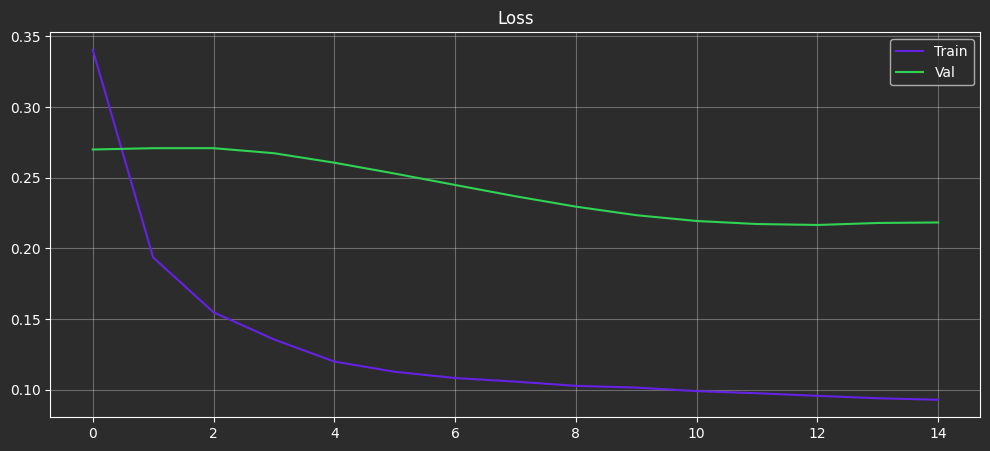

In [ ]:
plt.style.use('dark_background')
plt.rcParams['axes.facecolor'] = "#2c2c2cff"
plt.rcParams['figure.facecolor'] = "#2c2c2cff"

def show_results(history):
    fig, axes = plt.subplots(1, figsize=(12, 5))

    # Loss
    axes.plot(history.history['loss'], color="#6622e4", label='Train')
    axes.plot(history.history['val_loss'], color="#30d353", label='Val')
    axes.set_title('Loss')
    axes.grid(alpha=0.3)
    axes.legend()


plt.tight_layout()
plt.show()

show_results(history)

In [ ]:
decoded_imgs = model.predict(train_gray_ds)

205/205 ━━━━━━━━━━━━━━━━━━━━ 2s 13us/step


c:\Users\Utilisateur\Simplon\CONV_NN\.venv\Lib\site-packages\keras\src\trainers\epoch_iterator.py:164: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


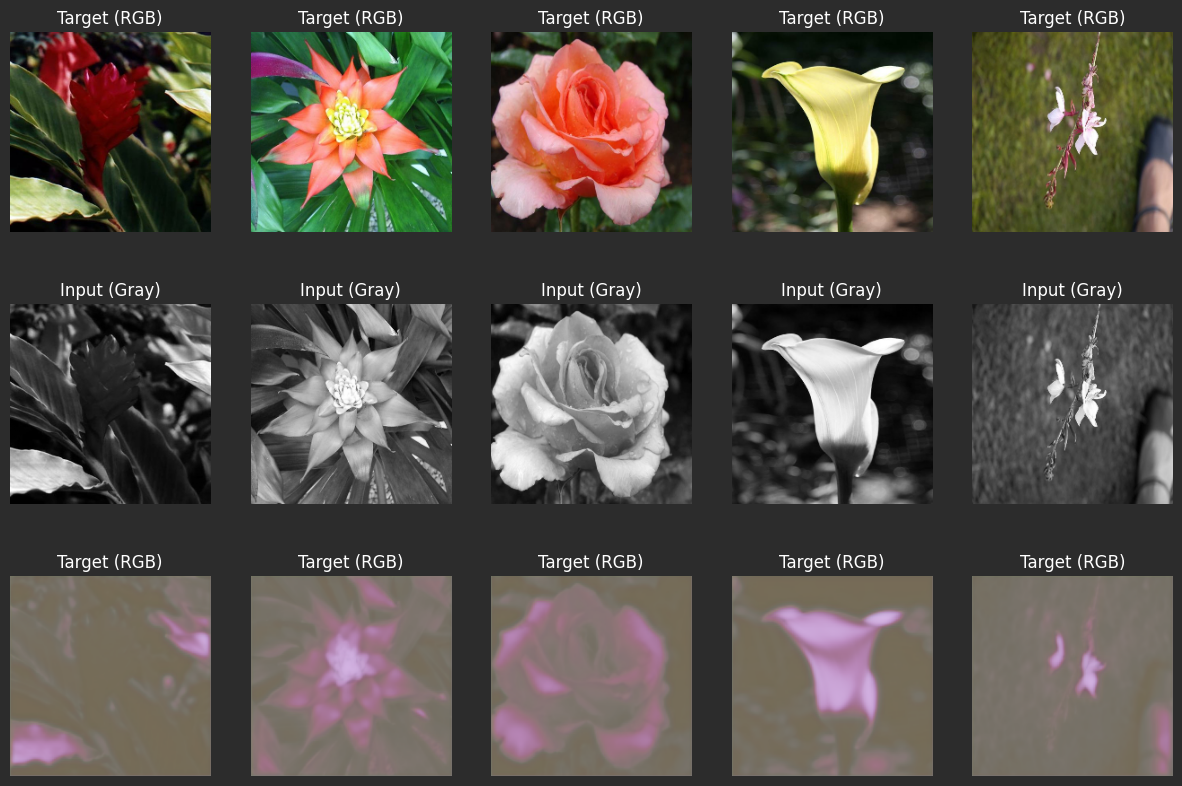

In [ ]:
def show_images(ds, decoded_imgs , n=5):
    
    
    for x_batch, y_batch in ds.take(1):
        fig, axes = plt.subplots(3, n, figsize=(15, 10))
        batch_size = x_batch.shape[0]

        for i in range(n):
            idx = np.random.randint(batch_size)

            # --- grayscale (input) ---
            axes[1, i].imshow(tf.squeeze(x_batch[idx]), cmap='gray')
            axes[1, i].axis('off')
            axes[1, i].set_title('Input (Gray)')

            # --- RGB (target) ---
            axes[0, i].imshow(tf.cast(y_batch[idx]*255, tf.uint8))
            axes[0, i].axis('off')
            axes[0, i].set_title('Target (RGB)')

            # --- RGB (decoded) ---
            axes[2, i].imshow(tf.cast(decoded_imgs[idx]*255, tf.uint8))
            axes[2, i].axis('off')
            axes[2, i].set_title('Target (RGB)')

        plt.show()
        break

show_images(train_gray_ds, decoded_imgs, n=5)


